In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gpflow
from gpflow.utilities import print_summary, positive
plt.style.use('ggplot')
%matplotlib inline
import tensorflow as tf
import math
from tensorflow import math as tm

PI = tf.constant(math.pi, dtype='float64')

# Replication of the paper by Lawrence et al., 2006

https://papers.nips.cc/paper/3119-modelling-transcriptional-regulation-using-gaussian-processes.pdf

#### Probesets

The original paper restricted their interest to 5 known targets of p53: 
- DDB2 -------------- (probeset 203409_at)
- p21 ----------------- (probeset 202284_s_at) (alias p21CIP1, CDKN1A)
- SESN1/hPA26 -- (probeset 218346_s_at)
- BIK ----------------- (probeset 205780_at)
- TNFRSF10b ----- (probeset 209294_x_at, 209295_at, 210405_x_at)

In [2]:
with open('barenco_processed.tsv', 'r') as f:
    index = 0
    df = pd.read_csv(f, delimiter='\t', index_col=0)
display(df.head(5))
columns = ['H_ARP1-0h.3', 'H_ARP1-2h.3', 'H_ARP1-4h.3', 'H_ARP1-6h.3', 'H_ARP1-8h.3', 'H_ARP1-10h.3', 'H_ARP1-12h.3']

c:\users\jacob\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (2,3,4,6,8,9,10,12,14,15,16,18,20,21,22,24,26,27,28,30,32,33,34,36,38,39,40,42,44,45,46,48,50,51,52,54,56,57,58,60,62,63,64,66,68,69,70,72,74,75,76,78,80,81,82,84,86,87,88,90,92,93,94,96,98,99,100,102,104,105,106,108,110,111,112,114,116,117,118,120,122,123,124,126) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,H_ARP1-0h,H_ARP1-0h.1,H_ARP1-0h.2,H_ARP1-0h.3,H_ARP1-0h.4,H_ARP1-0h.5,H_ARP1-2h,H_ARP1-2h.1,H_ARP1-2h.2,H_ARP1-2h.3,...,H_ARP3-10h.2,H_ARP3-10h.3,H_ARP3-10h.4,H_ARP3-10h.5,H_ARP3-12h,H_ARP3-12h.1,H_ARP3-12h.2,H_ARP3-12h.3,H_ARP3-12h.4,H_ARP3-12h.5
Scan REF,,,,,,,,,,,,,,,,,,,,,
Composite Element REF,Affymetrix:CHPProbeSetName,Affymetrix:CHPPairs,Affymetrix:CHPPairsUsed,Affymetrix:CHPSignal,Affymetrix:CHPDetection,Affymetrix:CHPDetectionPvalue,Affymetrix:CHPProbeSetName,Affymetrix:CHPPairs,Affymetrix:CHPPairsUsed,Affymetrix:CHPSignal,...,Affymetrix:CHPPairsUsed,Affymetrix:CHPSignal,Affymetrix:CHPDetection,Affymetrix:CHPDetectionPvalue,Affymetrix:CHPProbeSetName,Affymetrix:CHPPairs,Affymetrix:CHPPairsUsed,Affymetrix:CHPSignal,Affymetrix:CHPDetection,Affymetrix:CHPDetectionPvalue
AFFX-BioB-5_at,AFFX-BioB-5_at,20,20,131.7,Present,0.00039,AFFX-BioB-5_at,20,20,140.3,...,20,456.9,Present,0.00022,AFFX-BioB-5_at,20,20,410.1,Present,0.00017
AFFX-BioB-M_at,AFFX-BioB-M_at,20,20,260.6,Present,5.00E-05,AFFX-BioB-M_at,20,20,274.7,...,20,1210.7,Present,4.00E-05,AFFX-BioB-M_at,20,20,1102.9,Present,4.00E-05
AFFX-BioB-3_at,AFFX-BioB-3_at,20,20,142.7,Present,8.00E-05,AFFX-BioB-3_at,20,20,159.5,...,20,693.8,Present,5.00E-05,AFFX-BioB-3_at,20,20,560.1,Present,5.00E-05
AFFX-BioC-5_at,AFFX-BioC-5_at,20,20,348.8,Present,7.00E-05,AFFX-BioC-5_at,20,20,396.4,...,20,1324.1,Present,4.00E-05,AFFX-BioC-5_at,20,20,1052.6,Present,5.00E-05


In [3]:
assert df[df.duplicated()].size == 0

### Probeset Combination

TNFRSF10b has multiple probesets (probeset 209294_x_at, 209295_at, 210405_x_at) which should be combined.

It can be observed below that the log intensities have a similar pattern. Thus a popular way to combine is to take the average of the log intensities.

[8.8, 38.5, 61.2, 59.8, 60.6, 41.7, 22.1]
[34.2, 171.9, 220.3, 236.4, 302.5, 181.6, 152.9]
[5.8, 12.2, 53.6, 52.3, 67.6, 37.5, 23.7]


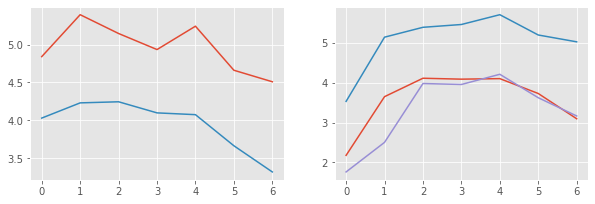

In [4]:
known_target_genes = ['203409_at', '202284_s_at', '218346_s_at', '205780_at']
genes = df[df.index.isin(known_target_genes)][columns]

plt.figure(figsize=(10,7))
plt.subplot(2,2,1)
p53 = df[df.index.isin(['211300_s_at', '201746_at'])][columns].astype(float)
for index, row in p53.iterrows():
    p53.loc[index] = np.log(list(row))
    plt.plot(list(row))

p53_mean = pd.Series(p53.mean(0), index=genes.columns, name='p53')

plt.subplot(2,2,2)
TNFRSF10b = df[df.index.isin(['209294_x_at', '209295_at', '210405_x_at'])][columns]
for index, row in TNFRSF10b.iterrows():
    print(list(row))
    TNFRSF10b.loc[index] = np.log(list(row))
    plt.plot(list(row))

TNFRSF10b_mean = pd.Series(TNFRSF10b.mean(0), index=genes.columns, name='TNFRSF10b')

In [5]:
genes.rename(index={
    '203409_at': 'DDB2', 
    '202284_s_at': 'p21',
    '218346_s_at': 'SESN1',
    '205780_at': 'BIK'
}, inplace=True)

genes = genes.append(TNFRSF10b_mean, ignore_index=False)
genes = genes.append(p53_mean, ignore_index=False).astype(np.float64)
#print(genes.loc[genes['Scan REF'] == pd.nan, 'Scan REF'])# = 'test'
display(genes)

,H_ARP1-0h.3,H_ARP1-2h.3,H_ARP1-4h.3,H_ARP1-6h.3,H_ARP1-8h.3,H_ARP1-10h.3,H_ARP1-12h.3
Scan REF,,,,,,,
p21,6.900000,175.400000,401.300000,289.200000,303.800000,157.300000,153.500000
DDB2,248.400000,723.100000,1059.000000,1328.200000,1471.400000,946.200000,952.000000
BIK,55.000000,161.200000,306.200000,354.300000,351.600000,170.900000,215.900000
SESN1,100.600000,209.100000,296.000000,314.900000,397.100000,209.500000,212.700000
TNFRSF10b,2.488278,3.766336,4.496896,4.504509,4.676661,4.185550,3.763612
p53,4.434580,4.811916,4.694975,4.515713,4.658209,4.162083,3.913238


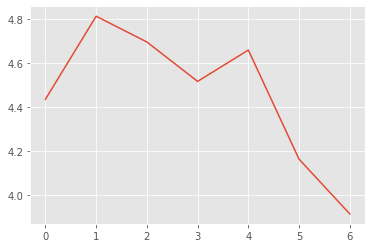

In [6]:
plt.plot(genes[genes.index == 'p53'].values[0])

In [7]:
X = genes[genes.index != 'p53'].values.T
Y = genes[genes.index == 'p53'].values[0]

print(X.shape,Y.shape)

(7, 5) (7,)


In [12]:
class ExpressionKernel(gpflow.kernels.Kernel):
    def __init__(self):
        super().__init__(active_dims=[0])
        self.lengthscale = gpflow.Parameter(1.0, transform=positive())
#         B = tf.ones(5)
#         self.B = gpflow.Parameter(B)
        D = tf.ones(5)
        self.D = gpflow.Parameter(D, transform=positive())
        S = tf.ones(5)
        self.S = gpflow.Parameter(S, transform=positive())

        
    def K(self, X, X2=None):
        if X2 is None:
            K_xx = tf.zeros([X.shape[0],X.shape[0]], dtype='float64')
            for j, _ in enumerate(X.T):
                for k, row in enumerate(X.T):
                    K_xx += self.k_xx(j, k)
            return K_xx
        else:
            print('HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH\nNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN')
            K_xf = tf.zeros([X.shape[0],X2.shape[0]], dtype='float64')
            for j, _ in enumerate(X.T):
                for k, _ in enumerate(X.T):
                    K_xf += self.k_xf(j, k)
            return K_xf
        

    def gamma(self, k):
        return self.D[k]*self.lengthscale/2

    def h(self, k, j, primefirst=False):
        l = self.lengthscale
        t_prime, t_, t_dist = self.get_distance_matrix(primefirst)
            
        multiplier = tm.exp(self.gamma(k))**2 / (self.D[j]+self.D[k])
        first_erf_term = tm.erf(t_dist/l - self.gamma(k)) + tm.erf(t_/l + self.gamma(k))
        second_erf_term = tm.erf(t_prime/l - self.gamma(k)) + tm.erf(self.gamma(k))
        
        return multiplier * (tf.multiply(tm.exp(-tm.multiply(self.D[k],t_dist)) , first_erf_term) - \
                             tf.multiply(tm.exp(-tm.multiply(self.D[k],t_prime)-self.D[j]) , second_erf_term))
    

    def k_xx(self, j, k):
        '''k_xx(t, tprime)'''
        return self.S[j]*self.S[k]*self.lengthscale*0.5*tm.sqrt(PI) * (self.h(k, j, primefirst=True) + self.h(j, k))


    def get_distance_matrix(self, primefirst=True):
        t = tf.cast(tf.range(7)*2, tf.float64)
        t_ = tf.transpose(tf.reshape(tf.tile(t, [7]), [ 7, tf.shape(t)[0]]))
        t_prime = tf.reshape(tf.tile(t, [7]), [ 7, tf.shape(t)[0]])
        if not primefirst:
            t_prime = tf.transpose(tf.reshape(tf.tile(t, [7]), [ 7, tf.shape(t)[0]]))
            t_ = tf.reshape(tf.tile(t, [7]), [ 7, tf.shape(t)[0]])

        return t_prime, t_, t_prime-t_
    
    #covariance between the gradient and the actual value
    def k_xf(self, j):
        print('AAAAAAAAAAAAAAAAAAAAAAAAAAAA')
        t_prime, t_, t_dist = self.get_distance_matrix()
        l = self.lengthscale
        erf_term = tm.erf(t_dist/l - self.gamma(j)) + tm.erf(t_/l + self.gamma(j))
        
        return S[j]*l*0.5*tm.sqrt(PI)*tm.exp(self.gamma(j))**2 *tm.exp(-self.D[j]*t_dist)*erf_term

    def K_diag(self, X):
        print('AAAAAAAAAAAAAAAAAAAAAAAAAAAAsssssssssssssssssssss')

        """I've used the fact that we call this method for K_ff when finding the covariance as a hack so
        I know if I should return K_ff or K_xx. In this case we're returning K_ff!!
        $K_{ff}^{post} = K_{ff} - K_{fx} K_{xx}^{-1} K_{xf}$"""
        print('k diag')
        _,_,t_dist = self.get_distance_matrix()
        K_ff = tf.math.exp(-(t_dist**2)/(self.lengthscale**2))
        return K_ff

k_exp = ExpressionKernel()
print_summary(k_exp, fmt='notebook')

k_exp.K(X)

name,class,transform,trainable,shape,dtype,value
ExpressionKernel.lengthscale,Parameter,Softplus,True,(),float64,1.0
ExpressionKernel.D,Parameter,Softplus,True,"(5,)",float64,"[1., 1., 1...."
ExpressionKernel.S,Parameter,Softplus,True,"(5,)",float64,"[1., 1., 1...."


<tf.Tensor: shape=(7, 7), dtype=float64, numpy=
array([[ 0.00000000e+00,  3.82962265e+00,  5.30099752e-01,
         7.17412351e-02,  9.70912037e-03,  1.31398656e-03,
         1.77828743e-04],
       [ 3.82962265e+00,  2.43960581e+01,  5.56411786e+00,
        -1.16766143e+00, -2.08514829e+00, -2.20931664e+00,
        -2.22612100e+00],
       [ 5.30099752e-01,  5.56411786e+00,  2.82610578e+01,
         7.75277581e+00,  7.88909737e-01, -1.59986666e-01,
        -2.88405841e-01],
       [ 7.17412351e-02, -1.16766143e+00,  7.75277581e+00,
         2.87945658e+01,  8.05563104e+00,  1.06054949e+00,
         1.07428531e-01],
       [ 9.70912037e-03, -2.08514829e+00,  7.88909737e-01,
         8.05563104e+00,  2.88667683e+01,  8.09661805e+00,
         1.09731195e+00],
       [ 1.31398656e-03, -2.20931664e+00, -1.59986666e-01,
         1.06054949e+00,  8.09661805e+00,  2.88765398e+01,
         8.10216504e+00],
       [ 1.77828743e-04, -2.22612100e+00, -2.88405841e-01,
         1.07428531e-01,  1.0

In [13]:
model = gpflow.models.GPR(data=(X, Y), kernel=k_exp, mean_function=None)

opt = gpflow.optimizers.Scipy()

print_summary(model)
def objective_closure():
    ret = - model.log_marginal_likelihood()
    print_summary(model)
    return ret
opt_logs = opt.minimize(objective_closure,
                        model.trainable_variables,
                        options=dict(maxiter=20))
print_summary(model)


name                     class      transform    trainable    shape    dtype    value
-----------------------  ---------  -----------  -----------  -------  -------  --------------
GPR.kernel.lengthscale   Parameter  Softplus     True         ()       float64  1.0
GPR.kernel.D             Parameter  Softplus     True         (5,)     float64  [1., 1., 1....
GPR.kernel.S             Parameter  Softplus     True         (5,)     float64  [1., 1., 1....
GPR.likelihood.variance  Parameter  Softplus     True         ()       float64  1.0
name                     class      transform    trainable    shape    dtype    value
-----------------------  ---------  -----------  -----------  -------  -------  --------------
GPR.kernel.lengthscale   Parameter  Softplus     True         ()       float64  1.0
GPR.kernel.D             Parameter  Softplus     True         (5,)     float64  [1., 1., 1....
GPR.kernel.S             Parameter  Softplus     True         (5,)     float64  [1., 1., 1....
GPR.li

InvalidArgumentError: Cholesky decomposition was not successful. The input might not be valid. [Op:Cholesky]